In [66]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. ETL

In [67]:
df = pd.read_csv('appl_1980_2014.csv', index_col = 0, parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2014-07-08,96.27,96.80,93.92,95.35,65130000,95.35
2014-07-07,94.14,95.99,94.10,95.97,56305400,95.97
2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03
2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52


In [68]:
#delete all the columns, use only Close
#today task: by 16:00, make a prediction
#use whatever window_size you want
#submit Google Classroom

## 2. EDA

In [69]:
len(df)

8465

In [70]:
df.drop('Open', inplace=True, axis=1)
df.drop('High', inplace=True, axis=1)
df.drop('Low', inplace=True, axis=1)
df.drop('Volume', inplace=True, axis=1)
df.drop('Adj Close', inplace=True, axis=1)

In [71]:
df.head()

,Close
Date,
2014-07-08,95.35
2014-07-07,95.97
2014-07-03,94.03
2014-07-02,93.48
2014-07-01,93.52


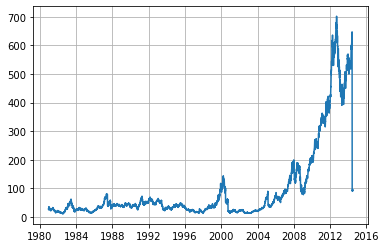

In [72]:
plt.plot(df['Close'])
plt.grid()

## 3. Feature Extraction

In [73]:
y = df['Close'].values.astype('float')
y.shape

(8465,)

In [74]:
test_size = 10

train_set = y[:-test_size]
test_set  = y[-test_size:]

In [75]:
len(train_set), len(test_set)

(8455, 10)

## 4. Preprocessing

In [76]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

In [77]:
train_minmax = scaler.fit_transform(train_set.reshape(-1, 1))

In [78]:
train_minmax = torch.FloatTensor(train_minmax).reshape(-1)

In [79]:
train_minmax.min(), train_minmax.max(), train_minmax.mean()

(tensor(-1.), tensor(1.), tensor(-0.7464))

In [80]:
train_minmax = torch.FloatTensor(train_minmax).reshape(-1)

## 5. Create the batch creator

In [81]:
window_size = 10

def input_data(seq, window_size, label_size=1):
    out = []
    total_length = len(seq)
    for i in range(total_length-window_size):  #if not, we will go out of bound
        window = seq[i:i+window_size]
        label  = seq[i+window_size:i+window_size+label_size]
        out.append((window, label))
    return out

In [82]:
train_data = input_data(train_minmax, window_size)
len(train_data)

8445

In [83]:
train_data[0]

(tensor([-0.7559, -0.7541, -0.7597, -0.7613, -0.7612, -0.7629, -0.7656, -0.7688,
         -0.7703, -0.7706]),
 tensor([-0.7690]))

## 6. Define the model

In [84]:
class chakyLSTM(nn.Module):
    #why out_size = 1, because later on, we will label_size = 1
    def __init__(self, input_size = 1, hidden_size=100, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm   = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size) #taking the last hidden state
        
        #optional
        #h0, c0
        #(D*num layer, N, Hin)
        self.hidden = (torch.zeros(1, 1, hidden_size),
                       torch.zeros(1, 1, hidden_size))
        
    def forward(self, seq):
        #seq shape: (10)
        seq = seq.reshape(len(seq), 1, -1)
        #seq shape: (10, 1, 1)
        out, (_, _) = self.lstm(seq, self.hidden) #you don't need self.hidden
        #out shape: (L, N, Hout * D) ==> (10, 1, 100)
        out = out[-1, :, :] #(B, Hout)
        #out shape: (1, 100)
        out = self.linear(out)
        #out shape: (1, 1)
        return out

## 7. Training

In [85]:
torch.manual_seed(999)
model = chakyLSTM()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [86]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

   400
 40000
   400
   400
   100
     1
______
 41301


In [87]:
epochs = 10
loss_vals = []

for e in range(epochs):
    
    for seq, ytrain in train_data:
        #seq: (10, ); target: (1, )
        
        yhat = model(seq) #1. predict
        yhat = yhat.reshape(-1) #I think you don't need this
        loss = criterion(yhat, ytrain) #2. loss
        loss_vals.append(loss.item())
        optimizer.zero_grad() #3. clear gradients
        loss.backward()  #4. backpropagate
        optimizer.step() #5. update
    
    print(f'Epoch: {e:2.0f} - Loss: {loss}')

Epoch:  0 - Loss: 5.033376737628714e-08
Epoch:  1 - Loss: 4.6412769734160975e-05
Epoch:  2 - Loss: 4.203107164357789e-05
Epoch:  3 - Loss: 2.2694754079566337e-05
Epoch:  4 - Loss: 2.0826171748922206e-05
Epoch:  5 - Loss: 2.3565860374219483e-06
Epoch:  6 - Loss: 8.960162745097477e-07
Epoch:  7 - Loss: 1.3410171959549189e-05
Epoch:  8 - Loss: 1.8915816326625645e-05
Epoch:  9 - Loss: 3.14124881697353e-05


In [94]:
#loss_vals

## 8. Plot the loss

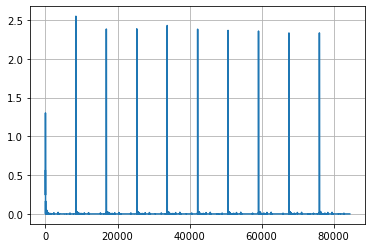

In [95]:
plt.plot(loss_vals)
plt.grid()

## 9. Inference

In [88]:
future = window_size

#prepare a list of predictions and append on this list
preds = train_minmax[-window_size:].tolist()

#usually we do with torch.no_grad():
model.eval() #same effect as no_grad(): all gradients are turned off; dropout and batchnorm off...
#i just read the documentation and double check
#model.eval() turns off dropout and batchnorm during testing, but not gradients

for _ in range(future):
    #act as the current train
    seq = torch.FloatTensor(preds[-window_size:])
    with torch.no_grad():
        yhat = model(seq)
        yhat = yhat.reshape(-1)
        preds.append(yhat.item())
        
preds[-window_size:]

[-0.9294388294219971,
 -0.930277407169342,
 -0.9300442337989807,
 -0.929993212223053,
 -0.9299883842468262,
 -0.9299923777580261,
 -0.9299954175949097,
 -0.9299981594085693,
 -0.9299983382225037,
 -0.9299976825714111]

In [89]:
test_set

array([35.5 , 32.5 , 30.88, 29.63, 28.25, 26.63, 25.87, 25.25, 27.25,
       28.75])

In [90]:
preds_real = scaler.inverse_transform(np.array(preds).reshape(-1, 1))

In [91]:
preds_real[-window_size:]

array([[35.38241249],
       [35.09264195],
       [35.17321501],
       [35.19084552],
       [35.19251382],
       [35.19113387],
       [35.19008345],
       [35.18913602],
       [35.18907423],
       [35.18930079]])

In [92]:
test_set

array([35.5 , 32.5 , 30.88, 29.63, 28.25, 26.63, 25.87, 25.25, 27.25,
       28.75])

In [100]:
X = df.index
X_test_set  = X[-test_size:]
X_test_set

DatetimeIndex(['1980-12-26', '1980-12-24', '1980-12-23', '1980-12-22',
               '1980-12-19', '1980-12-18', '1980-12-17', '1980-12-16',
               '1980-12-15', '1980-12-12'],
              dtype='datetime64[ns]', name='Date', freq=None)

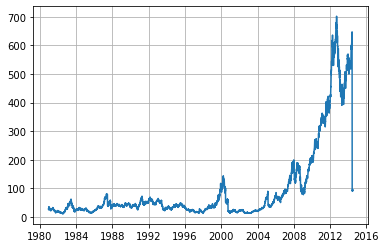

In [96]:
plt.plot(df['Close'])
plt.grid()

In [103]:
len(preds_real)

20

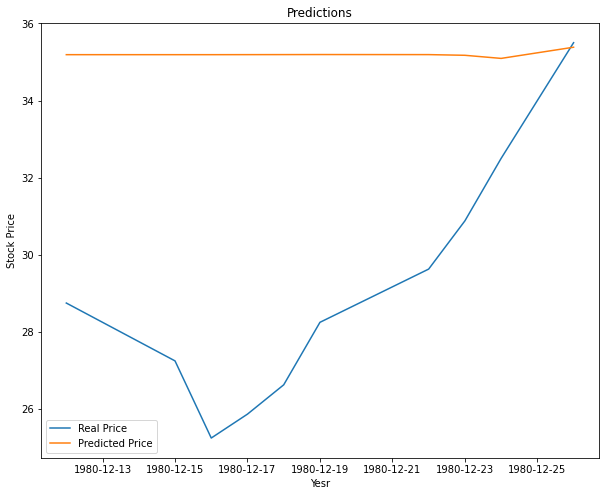

In [107]:
f = plt.figure(figsize=(10, 8))
plt.plot(X_test_set, test_set, label='Real Price')
plt.plot(X_test_set, preds_real[-window_size:], label='Predicted Price')
plt.xlabel('Yesr')
plt.ylabel('Stock Price')
plt.title('Predictions')
plt.legend()
plt.show()